Load from preprocessing

In [1]:
import joblib

preprocessor = joblib.load("preprocessor.pkl")
X_train = joblib.load("X_train.pkl")
X_test = joblib.load("X_test.pkl")
y_train = joblib.load("y_train.pkl")
y_test = joblib.load("y_test.pkl")

print("Objects loaded successfully!")

Objects loaded successfully!


# 1. Prepare data for the neural network

In [2]:
import numpy as np

# Apply the same preprocessing as for the ML models
X_train_nn = preprocessor.transform(X_train)
X_test_nn = preprocessor.transform(X_test)

# Convert y to numpy arrays
y_train_nn = np.array(y_train)
y_test_nn = np.array(y_test)

print("Train shape (NN):", X_train_nn.shape, y_train_nn.shape)
print("Test shape  (NN):", X_test_nn.shape, y_test_nn.shape)

Train shape (NN): (1000, 1299) (1000,)
Test shape  (NN): (250, 1299) (250,)


After applying the preprocessing pipeline (scaling + OneHotEncoding), the input
matrices for the neural network reached:

- Train set: (1000 samples, 1299 features)
- Test set:  (250 samples, 1299 features)

The relatively high number of features (1299) is expected, because most
variables in the dataset are categorical. The OneHotEncoder expands each
categorical variable into as many binary columns as there are categories, which
significantly increases the dimensionality. This numerical representation is
required for neural networks, which can only process continuous numerical
inputs.

The target vectors have shapes (1000,) and (250,), corresponding to binary
labels (`treatment`: 0 or 1).


# 2. Simple MLP model (scikit-learn)

In [3]:
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, classification_report
)

# Pipeline: same preprocessing as RF/XGB + MLP
mlp_pipe = Pipeline(steps=[
    ("prep", preprocessor),
    ("mlp", MLPClassifier(
        hidden_layer_sizes=(64, 32),  # 2 hidden layers
        activation="relu",
        solver="adam",
        max_iter=200,
        random_state=42,
        early_stopping=True
    ))
])

# Train
mlp_pipe.fit(X_train, y_train)

# Predict
y_pred_mlp = mlp_pipe.predict(X_test)
# For the ROC-AUC, we get the probability of class 1
y_prob_mlp = mlp_pipe.predict_proba(X_test)[:, 1]

print("MLP — Test set metrics")
print("Accuracy :", f"{accuracy_score(y_test, y_pred_mlp):.3f}")
print("Precision:", f"{precision_score(y_test, y_pred_mlp):.3f}")
print("Recall   :", f"{recall_score(y_test, y_pred_mlp):.3f}")
print("F1-score :", f"{f1_score(y_test, y_pred_mlp):.3f}")
print("ROC-AUC  :", f"{roc_auc_score(y_test, y_prob_mlp):.3f}")

print("\nClassification report:\n")
print(classification_report(y_test, y_pred_mlp))

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


MLP — Test set metrics
Accuracy : 0.724
Precision: 0.736
Recall   : 0.706
F1-score : 0.721
ROC-AUC  : 0.816

Classification report:

              precision    recall  f1-score   support

           0       0.71      0.74      0.73       124
           1       0.74      0.71      0.72       126

    accuracy                           0.72       250
   macro avg       0.72      0.72      0.72       250
weighted avg       0.72      0.72      0.72       250



# ROC curve & Confusion Matrix


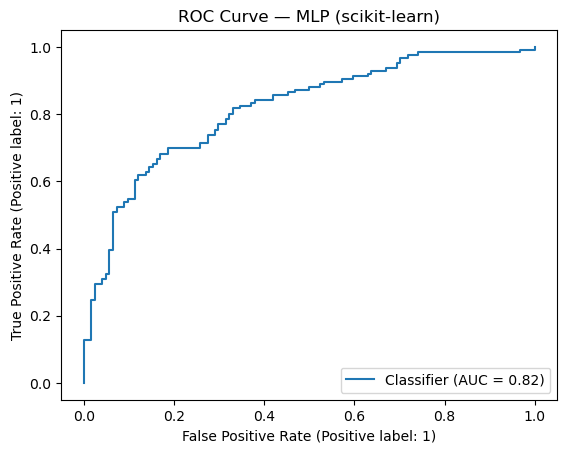

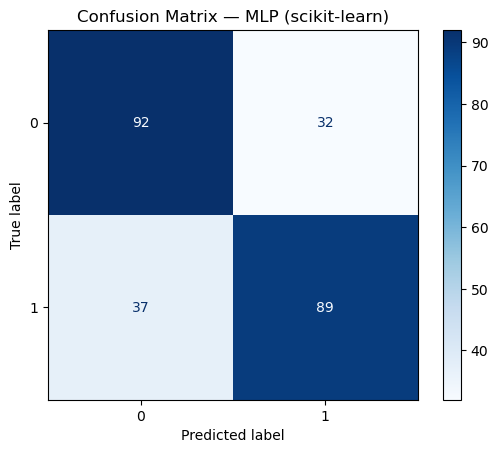

In [4]:
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# ROC curve
RocCurveDisplay.from_predictions(y_test, y_prob_mlp)
plt.title("ROC Curve — MLP (scikit-learn)")
plt.show()

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_mlp, cmap="Blues")
plt.title("Confusion Matrix — MLP (scikit-learn)")
plt.show()

### Interpretation

We implemented a simple fully connected neural network (MLP) with two hidden
layers (64 and 32 neurons, ReLU activation).
ReLU (Rectified Linear Unit) was used as the activation function in the hidden
layers. ReLU is defined as ReLU(x) = max(0, x), which keeps positive values
unchanged and sets all negative values to zero.

This architecture corresponds to a standard multilayer perceptron.

Due to TensorFlow DLL loading issues on the local machine, the MLP was trained
using `MLPClassifier` from scikit-learn, which provides an equivalent neural
architecture for binary classification.

On the test set, the model obtains the following metrics:

- **Accuracy:** 0.724  
- **Precision:** 0.736  
- **Recall:** 0.706  
- **F1-score:** 0.721  
- **ROC-AUC:** 0.816  

These results are lower than the ensemble methods developed in previous
sections (Random Forest, XGBoost, Soft Voting), which reach F1-scores around
*0.76–0.78* and ROC-AUC values above 0.84.

This behaviour is expected:  
MLPs typically require large datasets and continuous features to outperform
tree-based models. In contrast, our dataset is small, tabular, and heavily
one-hot encoded, a setting where tree ensembles are known to perform better.
  
Therefore, while the neural network successfully learns non-linear patterns, it
does not match the performance of boosted trees or the voting ensemble.  
This confirms that, for this specific tabular problem, tree-based ensemble
methods remain the most suitable choice, while the MLP serves as a useful
deep-learning baseline for comparison.


# Slightly tuned MLP

In [5]:
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, classification_report
)

mlp_pipe = Pipeline(steps=[
    ("prep", preprocessor),
    ("mlp", MLPClassifier(
        hidden_layer_sizes=(128, 64),  # larger
        activation="relu",
        solver="adam",
        alpha=1e-4,
        learning_rate_init=1e-3,
        max_iter=500,
        early_stopping=True,
        n_iter_no_change=10,
        validation_fraction=0.2,
        random_state=42
    ))
])

mlp_pipe.fit(X_train, y_train)

y_pred_nn = mlp_pipe.predict(X_test)
y_prob_nn = mlp_pipe.predict_proba(X_test)[:, 1]

print("Tuned MLP (scikit-learn) — Test set metrics")
print("Accuracy :", f"{accuracy_score(y_test, y_pred_nn):.3f}")
print("Precision:", f"{precision_score(y_test, y_pred_nn):.3f}")
print("Recall   :", f"{recall_score(y_test, y_pred_nn):.3f}")
print("F1-score :", f"{f1_score(y_test, y_pred_nn):.3f}")
print("ROC-AUC  :", f"{roc_auc_score(y_test, y_prob_nn):.3f}")

print("\nClassification report:\n")
print(classification_report(y_test, y_pred_nn))

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Tuned MLP (scikit-learn) — Test set metrics
Accuracy : 0.764
Precision: 0.802
Recall   : 0.706
F1-score : 0.751
ROC-AUC  : 0.842

Classification report:

              precision    recall  f1-score   support

           0       0.73      0.82      0.78       124
           1       0.80      0.71      0.75       126

    accuracy                           0.76       250
   macro avg       0.77      0.76      0.76       250
weighted avg       0.77      0.76      0.76       250



# ROC curve & Confusion Matrix (MLP)

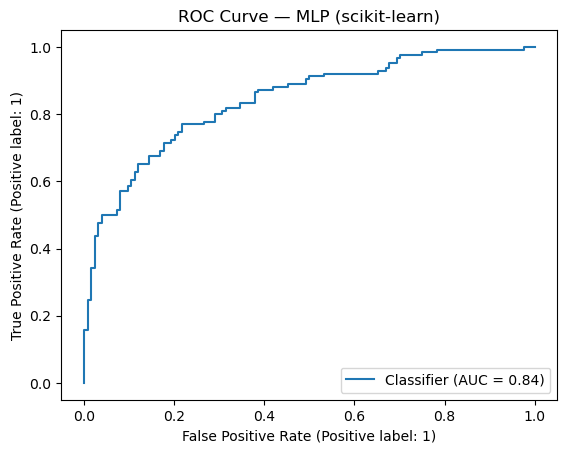

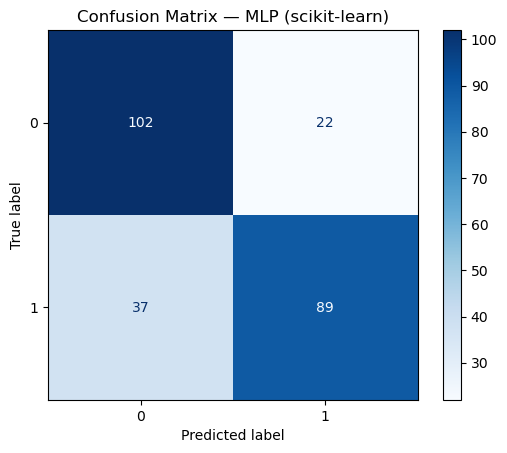

In [6]:
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# ROC curve
RocCurveDisplay.from_predictions(y_test, y_prob_nn)
plt.title("ROC Curve — MLP (scikit-learn)")
plt.show()

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_nn, cmap="Blues")
plt.title("Confusion Matrix — MLP (scikit-learn)")
plt.show()

### Tuned MLP — Results and interpretation

In the context of predicting whether an employee is at risk of mental health issues (proxy: having received treatment), this tuned MLP reaches a performance comparable to the best ensemble models.

To improve the performance of the initial simple neural network, we increased the model capacity (two hidden layers: 128 and 64 neurons), allowed more training iterations, and added a light L2 regularization (`alpha=1e-4`) with early stopping. This tuning significantly improved the model compared to the initial version.

The tuned MLP achieves:

- **Accuracy:** 0.764  
- **Precision:** 0.802  
- **Recall:** 0.706  
- **F1-score:** 0.751  
- **ROC-AUC:** 0.842  

These results position the neural network very close to the tree-based ensemble models. The F1-score is now comparable to Random Forest (0.764) and slightly below XGBoost (0.772) and Soft Voting (0.777). The precision of the MLP (0.802) is even higher than that of all ensemble models, meaning it makes fewer false positive predictions.

This shows that, although neural networks are not naturally the best performers on small tabular datasets with many one-hot encoded features, a moderately tuned MLP can still reach a level of performance close to the best ensemble methods. However, the overall ROC-AUC (0.842) remains slightly lower than XGBoost (0.865), confirming that boosted tree models remain the strongest choice for this type of
problem.

The tuned MLP nevertheless provides a strong deep learning baseline and enriches the global comparison of models.